# ガウス過程

In [1]:
import pymc3 as pm
import numpy as np 
import pandas as pd
import theano.tensor as tt
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
plt.style.use(["seaborn-colorblind", "seaborn-darkgrid"])
np.set_printoptions(precision=2)

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
/var/folders/zz/hwfwgc3s6wdfpwyj5z1s5y4m0000gn/T/ipykernel_67581/2827320444.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(["seaborn-colorblind", "seaborn-darkgrid"])
/var/folders/zz/hwfwgc3s6wdfpwyj5z1s5y4m0000gn/T/ipykernel_67581/2827320444.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0

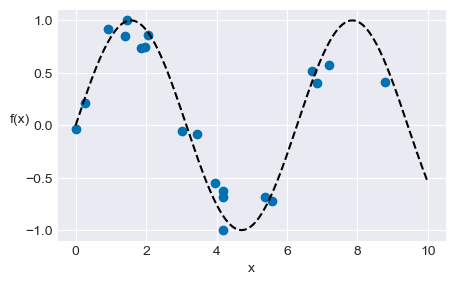

In [2]:
np.random.seed(1)
x = np.random.uniform(0, 10, size=20)
y = np.random.normal(np.sin(x), 0.2)
plt.figure(figsize=(5,3))
plt.plot(x, y, 'o')
true_x = np.linspace(0, 10, 200)
plt.plot(true_x, np.sin(true_x), 'k--')
plt.xlabel('x')
plt.ylabel('f(x)', rotation=0)
plt.savefig('img801.png')

In [3]:
# カーネル関数の定義
def gauss_kernel(x, n_knots):
    """
    Simple Gaussian radial kernel
    """
    knots = np.linspace(x.min(), x.max(), n_knots)
    w = 2

    return np.array([np.exp(-(x-k)**2/w) for k in knots])

/Users/hiroakimatsumoto/miniforge3/envs/pymc3/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, gamma]
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary in

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 8 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/hiroakimatsumoto/miniforge3/envs/pymc3/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


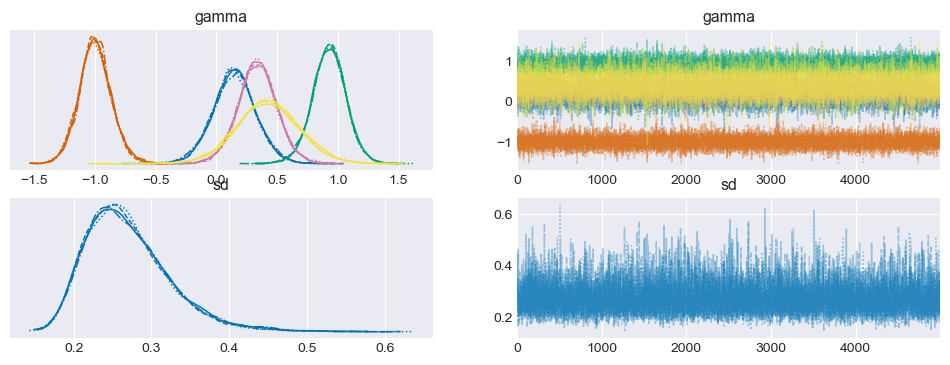

In [4]:
n_knots = 5

with pm.Model() as kernel_model:
    gamma = pm.Cauchy("gamma", alpha=0, beta=1, shape=n_knots)
    sd = pm.Uniform("sd", 0, 10)
    mu = pm.math.dot(gamma, gauss_kernel(x, n_knots))
    yl = pm.Normal("yl", mu=mu, sigma=sd, observed=y)

    kernel_trace = pm.sample(5000)

az.plot_trace(kernel_trace)
plt.savefig("img802.png")

/Users/hiroakimatsumoto/miniforge3/envs/pymc3/lib/python3.10/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


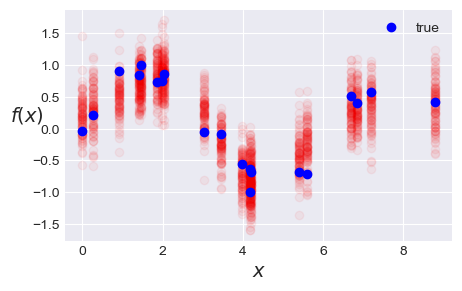

In [5]:
# 事後予測チェック
# ppc = pm.sample_ppc
ppc = pm.sample_posterior_predictive(kernel_trace, samples=100, model=kernel_model)
plt.figure(figsize=(5,3))
plt.plot(x, ppc["yl"].T, "ro", alpha=0.05)

plt.plot(x, y, "bo", label="true")
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$f(x)$", fontsize=14, rotation=0)
plt.legend()
plt.savefig("img803.png")

観測したデータ点以外のデータに対してモデルの振る舞いをチェックする

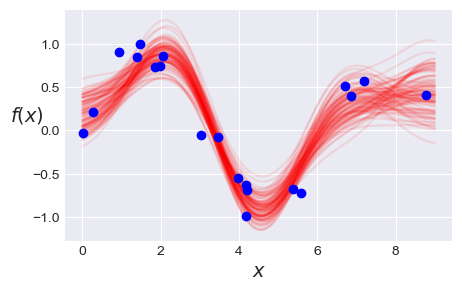

In [6]:
X_new = np.linspace(np.floor(x.min()), np.ceil(x.max()), 100)
k = gauss_kernel(X_new, n_knots=n_knots)
gamma_pred = kernel_trace["gamma"]

plt.figure(figsize=(5,3))
for i in range(100):
    idx = np.random.randint(0, len(gamma_pred))
    y_pred = np.dot(gamma_pred[idx], k)
    plt.plot(X_new, y_pred, "r-", alpha=0.1)
plt.plot(x, y, "bo")
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$f(x)$", fontsize=14, rotation=0)
plt.savefig("img804.png")


帯域幅$w$やノット数'n_knots'を変更した場合の効果は章末演習１で。  
他のタイプの関数にフィットさせた効果は章末演習２で。